In [1]:
import orca
import pandana as pdna
import pandas as pd
import scipy.stats as st
import numpy as np
import os

from urbansim.utils import networks
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep

from urbansim.utils import misc

from difflib import SequenceMatcher


import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

import glob

from scripts import datasources, models, variables

from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [89]:
persons = pd.read_csv('/home/data/fall_2018/chts_persons_w_zone_ids.csv')
household = pd.read_csv("/home/data/fall_2018/CHTS_csv_format/data/Deliv_HH.csv")

In [110]:
persons.columns[-100:]

Index(['SNAME_persons', 'SCITY_persons', 'SSTAT', 'SZIP_persons',
       'SXST1_persons', 'SXST2_persons', 'SXCORD_persons', 'SYCORD_persons',
       'SMODE', 'EDUCA', 'O_EDUCA', 'INTRV', 'PROXY', 'CMPLG', 'HVLOG',
       'PTRIPS', 'TOLLF', 'TOLLR1', 'TOLLR2', 'TOLLR3', 'TOLLR4', 'TOLLR5',
       'TOLLR6', 'TOLLR7', 'TOLLR8', 'TOLLR9', 'TOLLR10', 'TOLLB1', 'TOLLB2',
       'TOLLB3', 'TOLLB4', 'TOLLB5', 'TOLLB6', 'TOLLB7', 'TOLLB8', 'TOLLB9',
       'TOLLB10', 'HOVL', 'NOGOWHY', 'NOGOWHY_O', 'InComplete', 'Moto_trip',
       'WCTFIP_persons', 'WTRACT_persons', 'SCTFIP_persons', 'STRACT_persons',
       'WPrimaryCity_persons', 'WSTFIP_persons', 'W2PrimaryCity_persons',
       'W2STFIP_persons', 'SPrimaryCity_persons', 'SSTFIP_persons', 'PERWGT',
       'EXPPERWGT', 'WNAME_lookup', 'WCITY_lookup', 'WZIP_lookup',
       'WXST1_lookup', 'WXST2_lookup', 'WXCORD_lookup', 'WYCORD_lookup',
       'WNAME2_lookup', 'WCITY2_lookup', 'WZIP2_lookup', 'WXST2_1_lookup',
       'WXST2_2_lookup', 'SNAME

In [91]:
# Variables in the persons table
persons['worker'] = [1 if x == 1 else 0 for x in persons['EMPLY']]
persons['children'] = [1 if x < 18 else 0 for x in persons.AGE]
persons['TransitPass'] = persons.TRANS.apply(lambda x: 1 if x == 1 else 0)

#Creating person-based variables to merge onto Household table
person_var = persons.groupby(by ='SAMPN').agg({'PERNO': 'count', 
                                               'AGE': 'first', 
                                               'zone_id_home': 'first', 
                                               'EMPLY':'sum', 'children':'sum',
                                              'TransitPass':'sum'})

df_merge = household.merge(person_var, how = 'left', left_on = 'SAMPN', right_index=True )
df_merge = df_merge.dropna(subset=['PERNO', 'AGE', 'zone_id_home', 'children'])

In [92]:
df_merge.columns

Index(['SAMPN', 'RECMODE', 'RETMODE', 'INCEN', 'ILANG', 'CTFIP', 'AREA',
       'STRATA', 'STYPE', 'CEC', 'GTYPE', 'GFLAG', 'RIBUS', 'HHVEH', 'HHBIC',
       'VEHNEW', 'BUYER1', 'BUYER2', 'BUYER3', 'BUYER4', 'BUYER5', 'BUYER6',
       'BUYER7', 'BUYER8', 'RESTY', 'O_RESTY', 'OWN', 'O_OWN', 'TEN',
       'PREVCITY', 'PREVSTAT', 'PREVZIP', 'PHLNS', 'INCOM', 'HHSIZ',
       'NONRELAT', 'HHEMP', 'HHSTU', 'HHLIC', 'RECDate', 'ASSN', 'DOW',
       'HTRIPS', 'HCITY', 'HSTAT', 'HZIP', 'HXCORD', 'HYCORD', 'HHNOV1',
       'HHNOV2', 'HHNOV3', 'HHNOV4', 'HHNOV5', 'HHNOV6', 'HHNOV7', 'HHNOV8',
       'VEHOP', 'VEHPR', 'VEDTE', 'FUTUR', 'CMPLD', 'LDPER1', 'LDPER2',
       'LDPER3', 'LDPER4', 'LDPER5', 'LDPER6', 'LDPER7', 'LDPER8', 'LDTRP',
       'LDFlag', 'HPFlag', 'HH_Complete', 'GPS_Complete', 'HCTRACT',
       'HPrimaryCity', 'HSTFIP', 'MTC_FInalFlag', 'HHWGT', 'EXPHHWGT', 'PERNO',
       'AGE', 'zone_id_home', 'EMPLY', 'children', 'TransitPass'],
      dtype='object')

In [93]:
df_merge = df_merge.loc[:,['HHVEH','INCOM','PERNO','AGE', 'zone_id_home', 'EMPLY', 'children', 'TransitPass','HHLIC']]
df_merge = df_merge[df_merge.INCOM<50]
df_merge['cars_alt'] = [0 if x==0 else 1 if x == 1 else 2 if x==2 else 3 for x in df_merge['HHVEH'] ]

In [94]:
def normalize(data):
    ''' 
    Normalizes values in a Series
    Input: 
    data: Series-like
    
    Return: Normalized Series-like object
    '''
    return (data - np.mean(data)) / np.std(data)

to_normalize = ['INCOM','AGE','PERNO','children']

for i in to_normalize:
    df_merge[i] = normalize(df_merge[[i]])


In [104]:
#Splitting the data
x = df_merge.drop(['cars_alt','HHVEH'], axis = 1)
y = df_merge.loc[:,'cars_alt']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 2348)

<IPython.core.display.Javascript object>


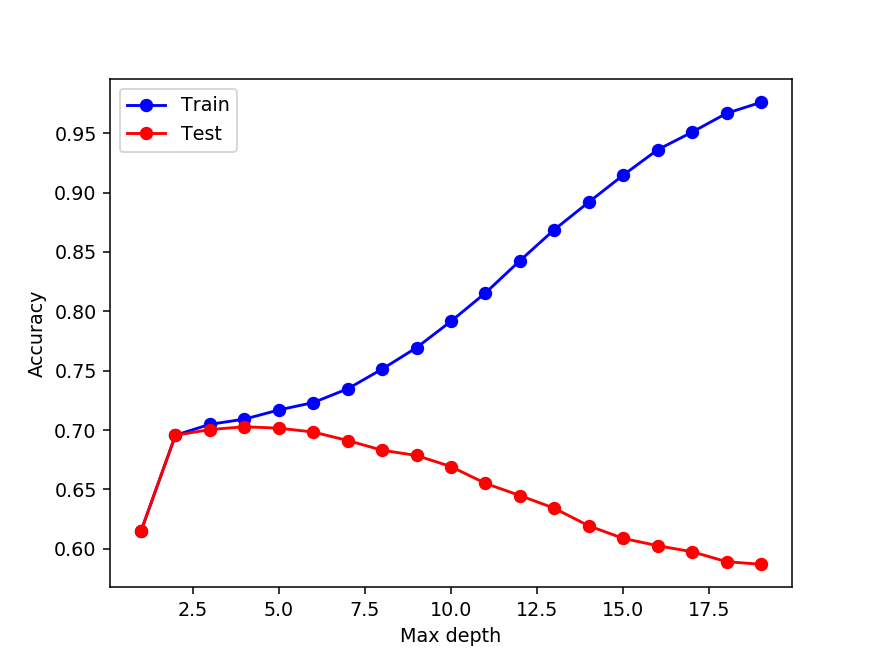

In [105]:
result_train = []
result_test = []
max_depth = range(1,20)
for i in max_depth:
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    scores = cross_validate(clf, X_train, y_train, cv=3, return_train_score=True)
    result_train.append(scores['train_score'].mean())
    result_test.append(scores['test_score'].mean()) 
    
plt.figure()
plt.plot(max_depth, result_train, '-o',color='blue',label='Train')
plt.plot(max_depth, result_test, '-o',color='red',label='Test')
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.legend()

<IPython.core.display.Javascript object>


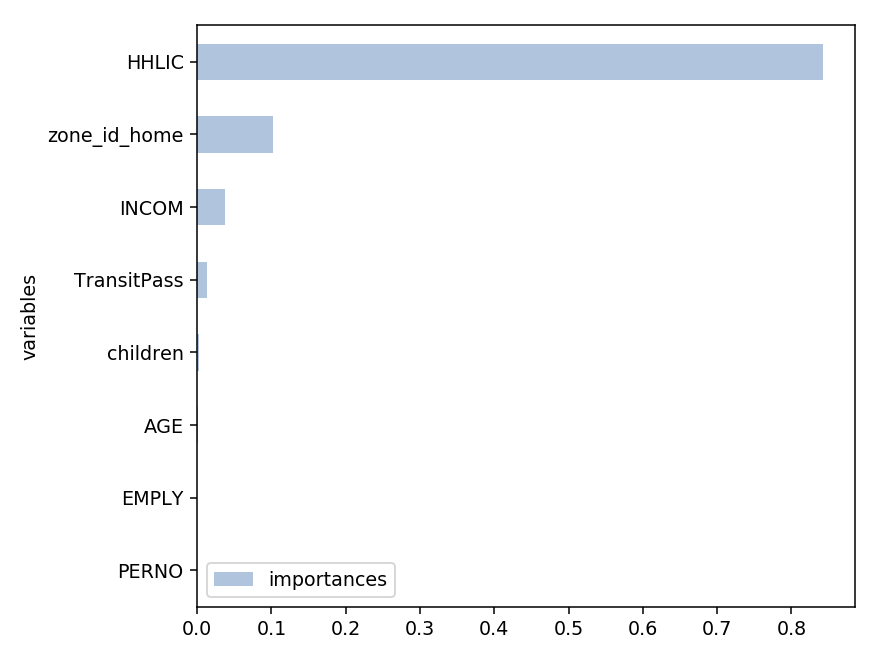

In [106]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=4)
clf.fit(X_train, y_train)

aa = pd.DataFrame({'importances':clf.feature_importances_,
                   'variables':X_train.columns}).sort_values(by = 'importances', ascending= True)

aa.plot.barh(x = 'variables', y='importances', color ='lightsteelblue')#, figsize =(15,5) )
plt.yticks()#(fontsize = 10)
plt.tight_layout()

In [101]:
pd.crosstab( y_test, clf.predict(X_test),normalize = 'index')

col_0,0,1,2,3
cars_alt,,,,
0,0.611399,0.326425,0.056995,0.005181
1,0.034884,0.676744,0.267442,0.020930
2,0.005495,0.109105,0.798273,0.087127
3,0.001773,0.044326,0.418440,0.535461


In [107]:
clf.score(X_test, y_test)

0.6983742649602214